In [1]:
import cv2
import numpy as np
import pylab
import random
import math
import pickle
import glob
import os
import pytesseract
import re

from src.detector.color_model_filter import *

In [2]:
#im = cv2.imread("data/006.jpg")
#file = "data/{:03d}.jpg".format(random.randint(1,404))
file = "data/269.jpg"
print(file)
im = cv2.imread(file)
im = im[30:, :, :]
im = cv2.resize(im, (1224,1024))

data/269.jpg


In [3]:

#im = cv2.GaussianBlur(im, (15, 15), 0)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)

bn_im = im
bn = np.zeros_like(bn_im)
for i in range(bn_im.shape[2]):
    min_val = bn_im[:, :, i].min()
    max_val = bn_im[:, :, i].max()
    bn[:, :, i] = (bn_im[:, :, i] - min_val) * (255 / (max_val - min_val))
    #pylab.imshow(np.concatenate([bn[:,:,i], bn_im[:, :, i]], axis=1), cmap=pylab.gray())
    #pylab.show()
    #print(bn[:, :, i].max(), bn[:, :, i].min())
#pylab.imshow(np.concatenate([bn, bn_im], axis=1), cmap=pylab.gray())
#pylab.show()


im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
print(im_hsv[:, :, 1].max(), im_hsv[:, :, 1].min())

(1024, 1224, 3)
191 0


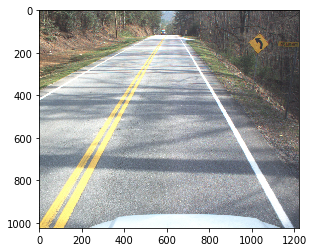

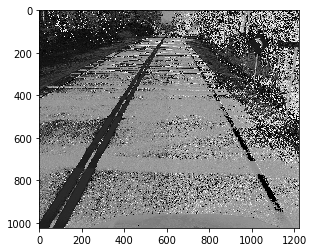

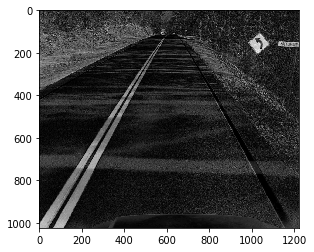

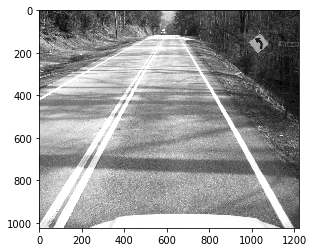

In [4]:
pylab.imshow(im_rgb)
pylab.show()
pylab.imshow(im_hsv[:,:,0], cmap=pylab.gray())
pylab.show()
pylab.imshow(im_hsv[:,:,1], cmap=pylab.gray())
pylab.show()
pylab.imshow(im_hsv[:,:,2], cmap=pylab.gray())
pylab.show()

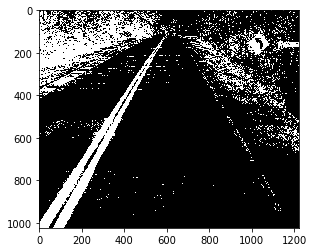

In [5]:
hue = im_hsv[:, :, 0]
hue = cv2.GaussianBlur(im_hsv[:, :, 0], (3,3), 0)
imhm = (hue < 35) * (hue > 10)
pylab.imshow(imhm, cmap=pylab.gray())
pylab.show()

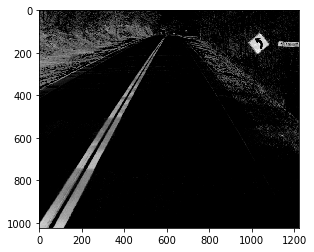

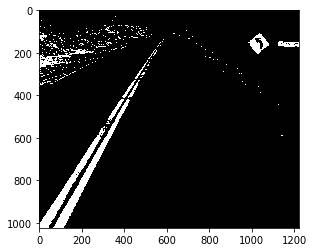

In [6]:
yellow_saturation = im_hsv[:, :, 1] * imhm
smax = yellow_saturation.max()
smin = yellow_saturation.min()  # == 0 ...
yellow_saturation = (yellow_saturation - smin) * (255 / (smax - smin))
yellow_saturation = cv2.GaussianBlur(yellow_saturation, (3,3), 0)
pylab.imshow(yellow_saturation, cmap=pylab.gray())
pylab.show()
imsm = (yellow_saturation > 105)
pylab.imshow(imsm, cmap=pylab.gray())
pylab.show()

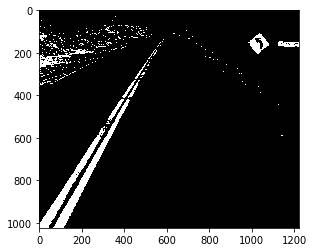

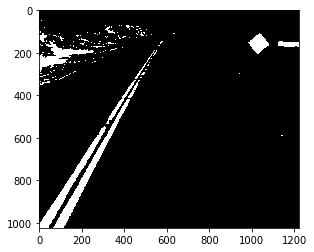

True

In [7]:
mask = (imsm).astype(np.uint8)

pylab.imshow(mask, cmap=pylab.gray())
pylab.show()
cv2.imwrite("masknf.png", mask  * 255 )

mask = filter_mask_noise(mask)

pylab.imshow(mask, cmap=pylab.gray())
pylab.show()
cv2.imwrite("mask.png", mask  * 255 )

In [8]:
#for_edges = im_hsv[:, :, 2].copy()
#for_edges = cv2.GaussianBlur(for_edges, (3,3), 0)
#edges = cv2.Canny(for_edges, 75, 150)
#edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))) # close sign
#cv2.imwrite("edges.png", edges)
#cv2.imwrite("edges_masked.png", edges * mask)
#pylab.imshow(edges, cmap=pylab.gray())
#pylab.show()

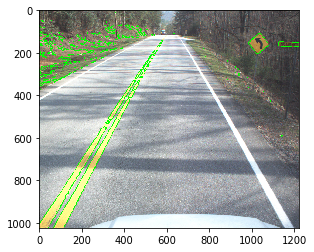

True

In [9]:
_, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imc = cv2.drawContours(im_rgb.copy(), contours, -1, (0,255,0), 2)
pylab.imshow(imc)
pylab.show()
cv2.imwrite("contours.png", cv2.cvtColor(imc, cv2.COLOR_RGB2BGR))

Perimeter: 24.727921843528748
Perimeter: 1282.444857597351
Area: 16510.0
Ratio: 6.226017613483836
Perimeter: 7.656854152679443
Perimeter: 1558.4519995450974
Area: 19460.5
Ratio: 7.800328341018062
Perimeter: 5.656854152679443
Perimeter: 5.656854152679443
Perimeter: 8.485281229019165
Perimeter: 18.97056245803833
Perimeter: 140.3675309419632
Area: 293.0
Ratio: 4.202867692564633
Perimeter: 28.727921724319458
Perimeter: 228.8355668783188
Area: 999.5
Ratio: 3.2744945390521205
Perimeter: 8.485281229019165
Perimeter: 559.2518669366837
Area: 3096.5
Ratio: 6.312825986439653
Perimeter: 5.656854152679443
Perimeter: 52.28427076339722
Perimeter: 64.18376553058624
Perimeter: 12.485281229019165
Perimeter: 9.071067690849304
Perimeter: 36.041630029678345
Perimeter: 40.62741661071777
Perimeter: 18.14213538169861
Perimeter: 7.656854152679443
Perimeter: 128.12489020824432
Area: 240.5
Ratio: 4.266109015300068
Perimeter: 5.656854152679443
Perimeter: 140.85281229019165
Area: 126.0
Ratio: 9.841029131972205
Per

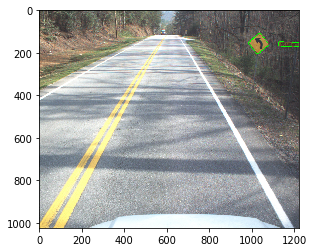

True

In [10]:
def can_contour_be_sign(c):
    per = cv2.arcLength(c,True)
    print("Perimeter:", per)
    if per < 110:
        return False
    a = cv2.contourArea(c)
    print("Area:", a)
    ratio = per**2 / (16 * a)
    print("Ratio:", ratio)
    if ratio > 3.0:
        return False
    height = np.min(c.reshape((-1, 2)), axis=0)[1]
    h_ratio = height**2 / a
    print("height ratio:", h_ratio)
    if h_ratio > 250:
        return False
    return True
filtered_contours = list(filter(can_contour_be_sign, contours))
#filtered_contours = list(map(cv2.convexHull, filtered_contours))

imcf = cv2.drawContours(im_rgb.copy(), filtered_contours, -1, (0,255,0), 2)
pylab.imshow(imcf)
pylab.show()
cv2.imwrite("contoursf.png", cv2.cvtColor(imcf, cv2.COLOR_RGB2BGR))

In [11]:
TWO_PI = 2 * math.pi

def get_not_convex_point(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    # Check for too few points
    if len(polygon) < 3:
        raise ValueError
    # Get starting information
    old_x, old_y = polygon[-2]
    new_x, new_y = polygon[-1]
    new_direction = math.atan2(new_y - old_y, new_x - old_x)
    angle_sum = 0.0
    pos_angle_list = []
    neg_angle_list = []
    # Check each point (the side ending there, its angle) and accum. angles
    for ndx, newpoint in enumerate(polygon):
        # Update point coordinates and side directions, check side length
        old_x, old_y, old_direction = new_x, new_y, new_direction
        new_x, new_y = newpoint
        new_direction = math.atan2(new_y - old_y, new_x - old_x)
        if old_x == new_x and old_y == new_y:
            raise ValueError  # repeated consecutive points
        # Calculate & check the normalized direction-change angle
        angle = new_direction - old_direction
        if angle <= -math.pi:
            angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
        elif angle > math.pi:
            angle -= TWO_PI
        if angle < 0.0:
            neg_angle_list.append(ndx - 1)
        else:
            pos_angle_list.append(ndx - 1)
        # Accumulate the direction-change angle
        angle_sum += angle
    if len(pos_angle_list) < len(neg_angle_list):
        return pos_angle_list, neg_angle_list
    else:
        return neg_angle_list, pos_angle_list
    
def split_signs(contour, non_convex_points):
    if len(non_convex_points) != 2:
        print("Contour with not exactly 2 non convex point ({} points) are not handled yet...".format(len(non_convex_points)))
        return []
    convex_contour_list = []
    poly_1 = np.concatenate([contour[:non_convex_points[0] + 1], contour[non_convex_points[-1]:]], axis=0)
    convex_contour_list.append(poly_1)
    poly_2 = contour[non_convex_points[0]:non_convex_points[-1] + 1]
    convex_contour_list.append(poly_2)
    return convex_contour_list

def try_to_split_signs(contour):
    shaped_contour = contour.reshape((-1, 2))
    non_convex_points, convex_point = get_not_convex_point(shaped_contour.copy())
    if len(non_convex_points) == 1:
        return [shaped_contour[convex_point]]
    else:
        return split_signs(shaped_contour.copy(), non_convex_points)
            
            

approx 7
approx 5
(1175, 160)
approx 6
(1033, 157)


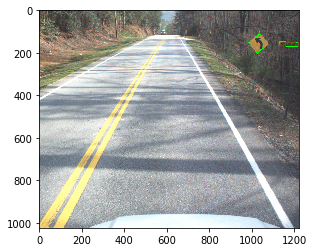

True

In [12]:
def approximate_contours(contour_list, block_recution=False):
    approx_contours = []
    for c in contour_list:
        if len(c) == 0:
            continue
        approx_c = cv2.approxPolyDP(c,0.012 * cv2.arcLength(c, True), True)
        print('approx', len(approx_c))
        #approx_contours.append(approx_c)
        if len(approx_c) == 4:
            cc = cv2.convexHull(c)
            approx_c = cv2.approxPolyDP(cc,0.065 * cv2.arcLength(cc, True), True)
            approx_contours.append(approx_c)
        elif 4 < len(approx_c) < 7:
            rect = cv2.minAreaRect(approx_c)
            rect_area = rect[1][0] * rect[1][1]
            if rect_area * 0.75 < cv2.contourArea(approx_c):
                m = cv2.moments(c)
                center = int(m['m10']/m['m00']), int(m['m01']/m['m00'])
                print(center)
                rect = (center, (rect[1][0] * 0.9, rect[1][1] * 0.9), rect[2])
                box = cv2.boxPoints(rect)
                box = np.int0(box).reshape((4, 1, 2))
                approx_contours.append(box)
        elif 12 > len(approx_c) > 6 and not block_recution:
            #probably two sign merged in one...
            splitted_contours = try_to_split_signs(approx_c)
            approx_contours += approximate_contours(splitted_contours, True)
    return approx_contours

aprox_cnt = approximate_contours(filtered_contours)

imacf = cv2.drawContours(im_rgb.copy(), aprox_cnt, -1, (0,255,0), 2)
pylab.imshow(imacf)
pylab.show()
cv2.imwrite("contoursfa.png", cv2.cvtColor(imacf, cv2.COLOR_RGB2BGR))

[[1218.  172.]
 [1130.  168.]
 [1131.  147.]
 [1219.  151.]]


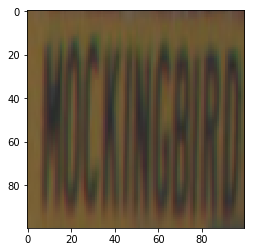

[[1027.  203.]
 [ 986.  154.]
 [1038.  110.]
 [1079.  159.]]


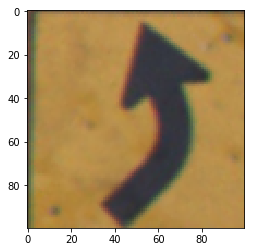

In [13]:
BOX_SIZE = 100
pts_dst_anti_horaire = np.float32([[0, BOX_SIZE], [BOX_SIZE, BOX_SIZE], [BOX_SIZE, 0], [0, 0]])
pts_dst_horaire = np.float32([[0, BOX_SIZE], [0, 0], [BOX_SIZE, 0], [BOX_SIZE, BOX_SIZE]])
signs_img = []
for c in aprox_cnt:
    if len(c) == 4:
        pts_src = np.array(c, dtype=np.float32).reshape((4, 2))
        print(pts_src)
        # ensure rotation is the same for every sign
        right_angle, bottom_angle = np.argmax(pts_src, axis=0)
        diff_to_bottom = pts_src - pts_src[bottom_angle]
        mask_bt_corner = diff_to_bottom[:, 1] < -10
        if mask_bt_corner.sum() < 3:  # if two corner are near the bottom we only take the left most one
            masked_corner = pts_src.copy()
            masked_corner[mask_bt_corner, :] = 8000  # mask out the others corner
            sorted_arg = np.argsort(masked_corner[:, 0])  # get the position of each corner sorted by x value
            bottom_angle = sorted_arg[0]
            right_angle = sorted_arg[1]
        pts_src = np.concatenate([pts_src[bottom_angle:], pts_src[:bottom_angle]])
        if right_angle == bottom_angle + 1:
            pts_dst = pts_dst_anti_horaire
        else:
            pts_dst = pts_dst_horaire
        # extract the sign
        transform_matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        sign = cv2.warpPerspective(im_rgb, transform_matrix, (BOX_SIZE, BOX_SIZE))
        signs_img.append(sign)
        pylab.imshow(sign)
        pylab.show()

In [14]:
#with open('sign_orb_descriptor.pikle', 'rb') as handle:
#    sign_template = pickle.load(handle)
#
#def tuple_to_kp(t):
#    return cv2.KeyPoint(x=t[0][0], y=t[0][1], _size=t[1], _angle=t[2], _response=t[3], _octave=t[4])
#    
#for template in sign_template:
#    template["kp"] = list(map(tuple_to_kp , template['keypoints']))
#
#orb = cv2.ORB_create()
#matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#GOOD_MATCH_PERCENT = 0.8
#for sign in signs_img:
#    kp = orb.detect(sign,None)
#    kp, des = orb.compute(sign, kp)
#    for template in sign_template:
#        # Match features.
#        matches = matcher.match(des, template['descriptor'], None)
#        print(len(matches))
#        if len(matches) == 0:
#            continue
#
#        # Sort matches by score
#        matches.sort(key=lambda x: x.distance, reverse=False)
#
#        # Remove not so good matches
#        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
#        matches = matches[:numGoodMatches]
#
#        # Draw top matches
#        template_image = cv2.cvtColor(cv2.imread(template['file']), cv2.COLOR_BGR2RGB)
#        
#        # Extract location of good matches
#        points1 = np.zeros((len(matches), 2), dtype=np.float32)
#        points2 = np.zeros((len(matches), 2), dtype=np.float32)
#        
#        for i, match in enumerate(matches):
#            points1[i, :] = kp[match.queryIdx].pt
#            points2[i, :] = template['kp'][match.trainIdx].pt
#            
#        # Find homography
#        h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
#        matchesMask = mask.ravel().tolist()
#        
#        print(mask.sum())
#        
#        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                   singlePointColor = None,
#                   matchesMask = matchesMask, # draw only inliers
#                   flags = 2)
#        
#        imMatches = cv2.drawMatches(sign, kp, template_image, template['kp'], matches, None, **draw_params)
#        pylab.imshow(imMatches)
#        pylab.show()

matching sign:


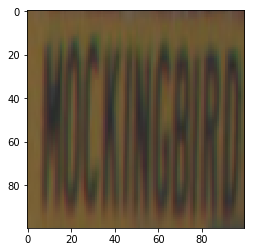

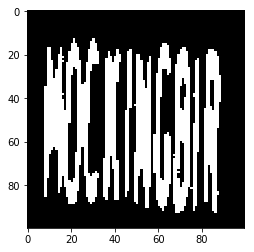

best match score is 0.5568567026194144


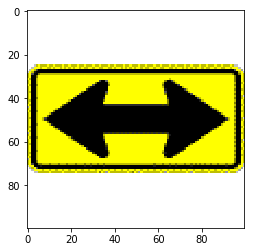

score: 0.5568567026194144


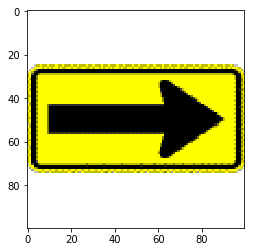

score: 0.5518739815317762


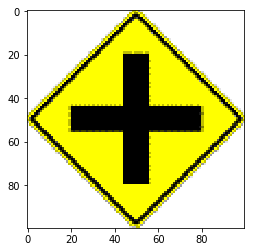

score: 0.4930662557781202
matching sign:


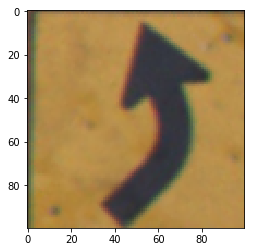

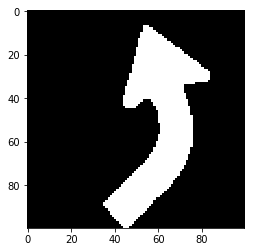

best match score is 0.8761345435130806


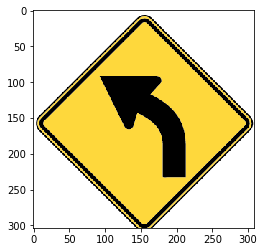

score: 0.8761345435130806


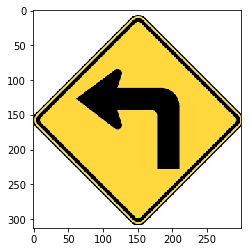

score: 0.6867154811715481


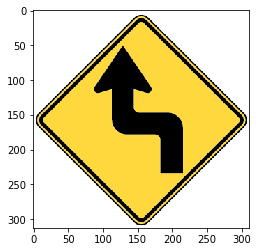

score: 0.6785714285714286


In [15]:
def template_iterator(path: str):
    files_list = glob.glob(os.path.join(path, "*sng*.png"))
    size_factors = [0.8, 0.9, 0.95]
    for t in files_list:
        template = cv2.imread(t, cv2.IMREAD_UNCHANGED)
        template = template[:, :, 3] == 255
        for s in size_factors:
            resize_ratio = BOX_SIZE * s / max(template.shape)
            tem = cv2.resize(template.astype(np.uint8), (0,0), fx=resize_ratio, fy=resize_ratio)
            yield t.split('_')[0], tem

def diamond_template_generator(sign_dir: str):
    for name, t in template_iterator(os.path.join(sign_dir, "diamond")):
        yield name, t, False
        yield name, np.flip(np.rot90(t), axis=1), True

def other_template_generator(sign_dir: str):
    for name, t in template_iterator(os.path.join(sign_dir, "others")):
        s = max(t.shape)
        t = cv2.resize(t, (s,s))
        yield name, t, False
        yield name, np.flip(t, axis=1), True
        
def template_generator(sign_path):
    for name, t, flipped in diamond_template_generator(sign_path):
        yield name, t, flipped
    for name, t, flipped in other_template_generator(sign_path):
        yield name, t, flipped

def speed_sign_creator(speed: int, path_to_base_sign="sign/speed_limit/W13-1P_out-01.png"):
    ss = cv2.imread(path_to_base_sign)
    ss = cv2.putText(ss, "{:02d}".format(speed), (45, 135), cv2.FONT_HERSHEY_SIMPLEX, 4.0, 0, 15)
    return ss
        
#for t in template_generator(templates_files):
#    print(t.shape)
#    pylab.imshow(t, cmap=pylab.gray())
#    pylab.show()

speed_regex = re.compile("[0-9][0-9]", re.MULTILINE)

for s, sign in enumerate(signs_img):
    print("matching sign:")
    pylab.imshow(sign)
    pylab.show()
    hsv_sign = cv2.cvtColor(sign, cv2.COLOR_RGB2HSV)
    threshold_factor = 0.45
    threshold = hsv_sign[:, :, 2].max() * threshold_factor + hsv_sign[:, :, 2].min() * (1.0 - threshold_factor)
    mask = (hsv_sign[:, :, 2] < threshold).astype(np.uint8)
    #print(hsv_sign[:, :, 2].min(), hsv_sign[:, :, 2].max())
    #pylab.imshow(hsv_sign[:, :, 2], cmap=pylab.gray())
    #pylab.show()
    #pylab.imshow(mask, cmap=pylab.gray())
    #pylab.show()
    # compute contours to (try to) only extract the sign pictogram
    _, s_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    signc = cv2.drawContours(sign.copy(), s_contours, -1, (0,255,0), -1)
    #pylab.imshow(signc)
    #pylab.show()
    # extract biggest area contour as the pictogram
    threshold = BOX_SIZE // 6
    for c in s_contours:
        c_centered_coord = (c > threshold) * (c < (BOX_SIZE - threshold))
        if np.sum(np.multiply(c_centered_coord[:, :, 0], c_centered_coord[:, :, 1])) == 0:
            # if noborder point is in the center, then remove the area
            mask = cv2.drawContours(mask, [c], -1, 0, -1) 
    pylab.imshow(mask, cmap=pylab.gray())
    pylab.show()
    mask_size = np.sum(mask)
    # OCR
    ocr_img = np.ones((BOX_SIZE * 2, BOX_SIZE * 2), dtype=np.uint8) * 255
    ocr_img[BOX_SIZE//2:BOX_SIZE+BOX_SIZE//2, BOX_SIZE//2:BOX_SIZE+BOX_SIZE//2] = 255 - mask * 255
    ocr_img = cv2.putText(ocr_img, "Sign", (3,35), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 0, 2)
    text = pytesseract.image_to_string(ocr_img, lang='eng').replace('\n', ' ')
    regex_match = speed_regex.search(text)
    if regex_match:
        print("speed limit: {}".format(regex_match.group()))
        ref_sign = speed_sign_creator(int(regex_match.group()))
        pylab.imshow(cv2.cvtColor(ref_sign, cv2.COLOR_BGR2RGB))
        pylab.show()
        continue
    
    template_best_score = {}
    max_score = 0
    best_template_info = {}
    for name, t, flipped in template_generator("sign"):
        res = cv2.matchTemplate(mask, t, cv2.TM_CCORR)
        score = np.max(res)
        score /= max(mask_size, np.sum(t))
        #pylab.imshow(t, cmap=pylab.gray())
        #pylab.show()
        #print("score:", score)
        if name not in template_best_score.keys() or template_best_score[name]['score'] < score:
            template_best_score[name] = {'file': name, 'flipped': flipped, 'score': score}
    matches = sorted(template_best_score.values(), key=lambda x: x['score'])
    print("best match score is {}".format(matches[-1]['score']))
    for i in range(3):
        sign_file = "{}_out-01.png".format(matches[-1-i]['file'])
        ref_sign = cv2.imread(sign_file)
        if matches[-1-i]['flipped']:
            ref_sign = np.flip(ref_sign, axis=1)
        pylab.imshow(cv2.cvtColor(ref_sign, cv2.COLOR_BGR2RGB))
        pylab.show()
        print("score:", matches[-1-i]['score'] )
    
    #ocr_img = cv2.putText(ocr_img, "20", (0,130), cv2.FONT_HERSHEY_SIMPLEX, 2.0, 0, 5)
    #ocr_img[32:37, :] = 0
    
    #pylab.imshow(ocr_img, cmap=pylab.gray())
    #cv2.imwrite("signM{}.png".format(s), ocr_img)
    #cv2.imwrite("sign{}.png".format(s), cv2.cvtColor(sign, cv2.COLOR_BGR2RGB))
    #pylab.show()
    